In [1]:
CLEAR_CACHE = False  # Update to True, when needed to clear cache

if CLEAR_CACHE:
    !rm -rf ~/.cache/huggingface/datasets

In [2]:
# Installing and Loading Dataset from HuggingFace

# !pip install -U datasets --quiet
# !pip install -U demoji --quiet

# Imports
from datasets import load_dataset
import pandas as pd

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import get_dataset_config_names

all_configs = get_dataset_config_names("McAuley-Lab/Amazon-Reviews-2023")
review_categories = [c for c in all_configs if c.startswith("raw_review_")]

print(f"Total Review Categories: {len(review_categories)}")
print("Available Categories:\n")
for c in review_categories:
    print("-", c.replace("raw_review_", ""))

The repository for McAuley-Lab/Amazon-Reviews-2023 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/McAuley-Lab/Amazon-Reviews-2023.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Total Review Categories: 34
Available Categories:

- All_Beauty
- Toys_and_Games
- Cell_Phones_and_Accessories
- Industrial_and_Scientific
- Gift_Cards
- Musical_Instruments
- Electronics
- Handmade_Products
- Arts_Crafts_and_Sewing
- Baby_Products
- Health_and_Household
- Office_Products
- Digital_Music
- Grocery_and_Gourmet_Food
- Sports_and_Outdoors
- Home_and_Kitchen
- Subscription_Boxes
- Tools_and_Home_Improvement
- Pet_Supplies
- Video_Games
- Kindle_Store
- Clothing_Shoes_and_Jewelry
- Patio_Lawn_and_Garden
- Unknown
- Books
- Automotive
- CDs_and_Vinyl
- Beauty_and_Personal_Care
- Amazon_Fashion
- Magazine_Subscriptions
- Software
- Health_and_Personal_Care
- Appliances
- Movies_and_TV


In [4]:
# Sampling 50K Records with Emoji-to-Text Conversion

from datasets import load_dataset
import pandas as pd
from itertools import islice
import demoji

# Download emoji mapping only once per session
demoji.download_codes()

def convert_emojis_to_text(text):
    return demoji.replace_with_desc(str(text), sep=" ")

# Define target categories (5 x 10K = 50K)
categories = [
    "raw_review_Electronics",
    "raw_review_Books",
    "raw_review_Home_and_Kitchen",
    "raw_review_Cell_Phones_and_Accessories",
    "raw_review_Sports_and_Outdoors"
]

combined_dfs = []

for cat in categories:
    print(f"\n Streaming category: {cat}")

    ds_iter = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        cat,
        split="full",
        streaming=True
    )

    batch = list(islice(ds_iter, 10000))
    df = pd.DataFrame(batch)

    print(" Columns loaded:", df.columns.tolist())

    required = ["text", "rating"]
    if not all(col in df.columns for col in required):
        print(f" Skipping {cat} — missing columns")
        continue

    df = df.dropna(subset=required)
    df = df.rename(columns={"text": "reviewText", "rating": "overall"})

    # Convert emojis in text to descriptive words
    df["reviewText"] = df["reviewText"].apply(convert_emojis_to_text)

    df["category"] = cat.replace("raw_review_", "").replace("_", " ")

    combined_dfs.append(df)


 Streaming category: raw_review_Electronics


/tmp/ipykernel_535/3401095526.py:9: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


 Columns loaded: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

 Streaming category: raw_review_Books
 Columns loaded: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

 Streaming category: raw_review_Home_and_Kitchen
 Columns loaded: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

 Streaming category: raw_review_Cell_Phones_and_Accessories
 Columns loaded: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

 Streaming category: raw_review_Sports_and_Outdoors
 Columns loaded: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']


In [5]:
# Merge all 5 categories
sample_50k_df = pd.concat(combined_dfs).reset_index(drop=True)

# Preview of sample data set
print(sample_50k_df.shape)
sample_50k_df.head()


(50000, 11)


,overall,title,reviewText,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,category
0,3.0,Smells like gasoline! Going back!,First & most offensive: they reek of gasoline ...,[{'small_image_url': 'https://m.media-amazon.c...,B083NRGZMM,B083NRGZMM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1658185117948,0,True,Electronics
1,1.0,Didn’t work at all lenses loose/broken.,These didn’t work. Idk if they were damaged in...,[],B07N69T6TM,B07N69T6TM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1592678549731,0,True,Electronics
2,5.0,Excellent!,I love these. They even come with a carry case...,[],B01G8JO5F2,B01G8JO5F2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1523093017534,0,True,Electronics
3,5.0,Great laptop backpack!,I was searching for a sturdy backpack for scho...,[],B001OC5JKY,B001OC5JKY,AGGZ357AO26RQZVRLGU4D4N52DZQ,1290278495000,18,True,Electronics
4,5.0,Best Headphones in the Fifties price range!,I've bought these headphones three times becau...,[],B013J7WUGC,B07CJYMRWM,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,1676601581238,0,True,Electronics


In [6]:
# Save Final Dataset to CSV
sample_50k_df.to_csv("amazon_reviews_50k_mixed.csv", index=False)

In [7]:
# Checking for Missing Values
missing = sample_50k_df.isnull().sum()
print("Missing Values in Each Column:\n", missing)


Missing Values in Each Column:
 overall              0
title                0
reviewText           0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
category             0
dtype: int64


In [8]:
# Load your 50K sample DataFrame (replace if using a different source)
df = sample_50k_df.copy()

# Preview the data
print("Sample Columns:", df.columns.tolist())
df.head()


Sample Columns: ['overall', 'title', 'reviewText', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'category']


,overall,title,reviewText,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,category
0,3.0,Smells like gasoline! Going back!,First & most offensive: they reek of gasoline ...,[{'small_image_url': 'https://m.media-amazon.c...,B083NRGZMM,B083NRGZMM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1658185117948,0,True,Electronics
1,1.0,Didn’t work at all lenses loose/broken.,These didn’t work. Idk if they were damaged in...,[],B07N69T6TM,B07N69T6TM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1592678549731,0,True,Electronics
2,5.0,Excellent!,I love these. They even come with a carry case...,[],B01G8JO5F2,B01G8JO5F2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1523093017534,0,True,Electronics
3,5.0,Great laptop backpack!,I was searching for a sturdy backpack for scho...,[],B001OC5JKY,B001OC5JKY,AGGZ357AO26RQZVRLGU4D4N52DZQ,1290278495000,18,True,Electronics
4,5.0,Best Headphones in the Fifties price range!,I've bought these headphones three times becau...,[],B013J7WUGC,B07CJYMRWM,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,1676601581238,0,True,Electronics


In [11]:
import pandas as pd
import re


# Basic cleaning: lowercase, remove punctuation/numbers
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # keep letters and spaces
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

# Apply to reviewText
df["cleaned_text"] = df["reviewText"].apply(clean_text)
df[["reviewText", "cleaned_text"]].head()


,reviewText,cleaned_text
0,First & most offensive: they reek of gasoline ...,first most offensive they reek of gasoline so ...
1,These didn’t work. Idk if they were damaged in...,these didnt work idk if they were damaged in s...
2,I love these. They even come with a carry case...,i love these they even come with a carry case ...
3,I was searching for a sturdy backpack for scho...,i was searching for a sturdy backpack for scho...
4,I've bought these headphones three times becau...,ive bought these headphones three times becaus...


In [13]:
# Convert 'overall' score (1 to 5) into sentiment
def map_sentiment(score):
    if score <= 2:
        return "Negative"
    elif score == 3:
        return "Neutral"
    else:
        return "Positive"

df["sentiment"] = df["overall"].apply(map_sentiment)
df["label"] = df["sentiment"].map({"Negative": 0, "Neutral": 1, "Positive": 2})
df[["overall", "sentiment", "label"]].value_counts()


overall  sentiment  label
5.0      Positive   2        32729
4.0      Positive   2         8837
3.0      Neutral    1         3787
1.0      Negative   0         2814
2.0      Negative   0         1833
Name: count, dtype: int64

In [14]:
# Check availability of essential columns
assert "cleaned_text" in df.columns, "Missing 'cleaned_text' column"
assert "sentiment" in df.columns, "Missing 'sentiment' column"

# Show sentiment value counts
df["sentiment"].value_counts()


sentiment
Positive    41566
Negative     4647
Neutral      3787
Name: count, dtype: int64

In [15]:
# Map sentiment strings to integers
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df["label"] = df["sentiment"].map(label_map)

# Check mapping
df[["sentiment", "label"]].head()


,sentiment,label
0,Neutral,1
1,Negative,0
2,Positive,2
3,Positive,2
4,Positive,2


<Axes: title={'center': 'Original Class Distribution'}, xlabel='sentiment'>

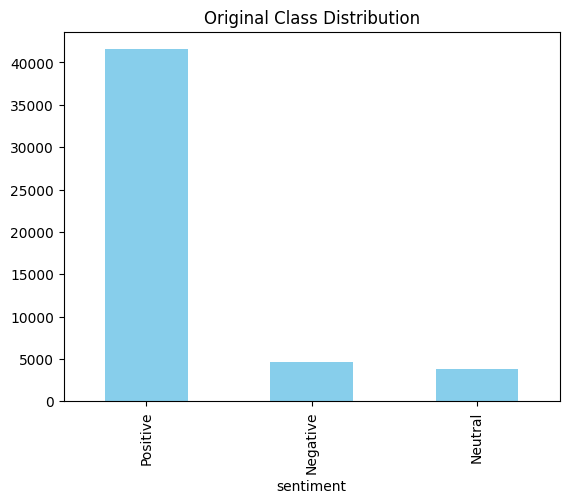

In [16]:
# Show original class distribution
df["sentiment"].value_counts().plot(kind="bar", title="Original Class Distribution", color="skyblue")


In [17]:
from sklearn.utils import resample

# Split by class
neg = df[df["label"] == 0]
neu = df[df["label"] == 1]
pos = df[df["label"] == 2]

# Determine balanced size (use fixed size or min class size)
min_samples = min(len(neg), len(neu), len(pos), 33333)

# Downsample all classes to balance
neg_down = resample(neg, n_samples=min_samples, replace=False, random_state=42)
neu_down = resample(neu, n_samples=min_samples, replace=False, random_state=42)
pos_down = resample(pos, n_samples=min_samples, replace=False, random_state=42)

# Combine and shuffle
balanced_df = pd.concat([neg_down, neu_down, pos_down]).sample(frac=1, random_state=42).reset_index(drop=True)


<Axes: title={'center': 'Balanced Class Distribution'}, xlabel='sentiment'>

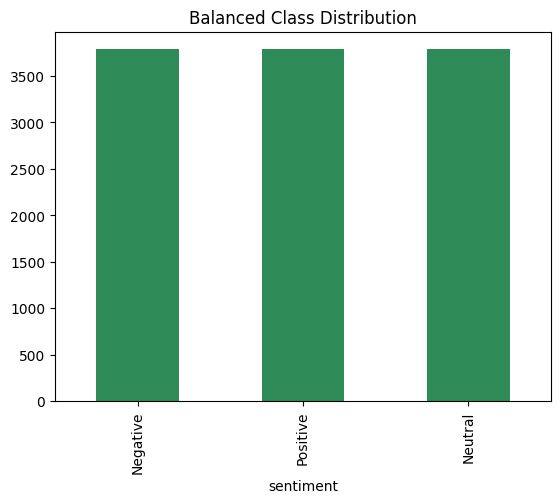

In [18]:
# Confirm balanced class distribution
balanced_df["sentiment"].value_counts().plot(kind="bar", title="Balanced Class Distribution", color="seagreen")


In [19]:
balanced_df["sentiment"].value_counts()

sentiment
Negative    3787
Positive    3787
Neutral     3787
Name: count, dtype: int64

In [20]:
# Check if cleaned_text and label exist in final DataFrame
assert "cleaned_text" in balanced_df.columns, "Missing 'cleaned_text' after processing"
assert "label" in balanced_df.columns, "Missing 'label' after processing"

# Save this as main input for next phase
df_final = balanced_df.copy()
df_final.head()


,overall,title,reviewText,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,category,cleaned_text,sentiment,label
0,2.0,‘Labyrinth Lost’ by Zoraida Córdova,animal sacrificing paranormal (witch) bisexual...,[],1492620947,1492620947,AFWVN52MRBWOTIK7UGXBWGOY4HBA,1480148185000,1,False,Books,animal sacrificing paranormal witch bisexual l...,Negative,0
1,5.0,Quality engraving and a great gift!,I bought these as &#34;thank you&#34; gifts fo...,[],B06X9CVQHM,B06X9CVQHM,AFNINAMLN5HIRILUWV7GVXWO7DWQ,1506562654140,0,True,Sports and Outdoors,i bought these as thank you gifts for the doct...,Positive,2
2,3.0,It's just okay,Maybe I didn't read descriptions enough? I pur...,[],B0BF9Q3VJC,B0BGK3Y8VY,AH4CGRSYSW5CWLRGQYRZKNJBUPAA,1668688138478,1,True,Electronics,maybe i didnt read descriptions enough i purch...,Neutral,1
3,2.0,Cheaply made,I have a MacBook Air and I would like to have ...,[{'small_image_url': 'https://m.media-amazon.c...,B07MF2KFR3,B07KXN1HRL,AFGDRVPCP742YM5MMLFIKZCGNNRQ,1635982397829,0,True,Electronics,i have a macbook air and i would like to have ...,Negative,0
4,5.0,affordable with great sound. Assembly could be...,"Wow, affordable with great sound. Assembly cou...",[],B00E4LGVUO,B07S764D9V,AHF5OLUZ6VKGFAJ7J5CIPI57O7GQ,1513822850451,0,True,Electronics,wow affordable with great sound assembly could...,Positive,2


In [21]:
# Already exists from your previous output
df_balanced_3class = balanced_df.copy()

# Preview shape and counts
print("Balanced 3-Class Dataset:", df_balanced_3class.shape)
print(df_balanced_3class["sentiment"].value_counts())


Balanced 3-Class Dataset: (11361, 14)
sentiment
Negative    3787
Positive    3787
Neutral     3787
Name: count, dtype: int64


In [22]:
# Step 1: Filter positive and negative reviews only
df_binary = df[df["sentiment"].isin(["Positive", "Negative"])].copy()

# Step 2: Encode binary labels
df_binary["label"] = df_binary["sentiment"].map({"Negative": 0, "Positive": 1})

# Step 3: Show class balance
print("Binary Sentiment Dataset:", df_binary.shape)
print(df_binary["sentiment"].value_counts())


Binary Sentiment Dataset: (46213, 14)
sentiment
Positive    41566
Negative     4647
Name: count, dtype: int64


In [23]:
# Step 1: Copy full dataset
df_full_weighted = df.copy()

# Step 2: Ensure label is mapped
df_full_weighted["label"] = df_full_weighted["sentiment"].map({"Negative": 0, "Neutral": 1, "Positive": 2})

# Step 3: Compute class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_full_weighted["label"]),
    y=df_full_weighted["label"]
)

# Step 4: Convert to dict format (needed for Keras or HuggingFace Trainer)
class_weights = {i: w for i, w in enumerate(class_weights_array)}

# Preview
print("Class distribution:", df_full_weighted["sentiment"].value_counts())
print("Computed Class Weights:", class_weights)


Class distribution: sentiment
Positive    41566
Negative     4647
Neutral      3787
Name: count, dtype: int64
Computed Class Weights: {0: np.float64(3.5865432895775053), 1: np.float64(4.4010210368805565), 2: np.float64(0.40096874047699244)}


In [24]:
print("df_balanced_3class:", df_balanced_3class.shape)
print("df_binary:", df_binary.shape)
print("df_full_weighted:", df_full_weighted.shape)


df_balanced_3class: (11361, 14)
df_binary: (46213, 14)
df_full_weighted: (50000, 14)


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Initialize results dictionary
sentiment_metrics_classical = {}


In [26]:
# Prepare input/output
X = df_balanced_3class["cleaned_text"]
y = df_balanced_3class["label"]

# Train/Test Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


Logistic Regression
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       757
           1       0.58      0.61      0.60       758
           2       0.79      0.76      0.78       758

    accuracy                           0.68      2273
   macro avg       0.68      0.68      0.68      2273
weighted avg       0.68      0.68      0.68      2273



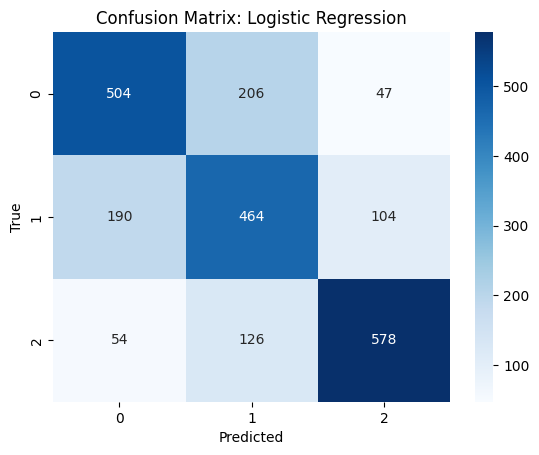

In [27]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_tfidf, y_train)
y_pred_lr = model_lr.predict(X_test_tfidf)

# Store results
sentiment_metrics_classical["Logistic Regression"] = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_lr, average='weighted'),
    "F1": f1_score(y_test, y_pred_lr, average='weighted')
}

# Output report
print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Support Vector Machine
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       757
           1       0.58      0.58      0.58       758
           2       0.77      0.75      0.76       758

    accuracy                           0.66      2273
   macro avg       0.66      0.66      0.66      2273
weighted avg       0.66      0.66      0.66      2273



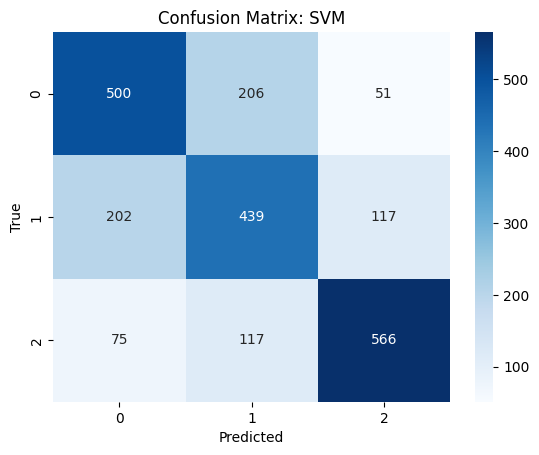

In [28]:
from sklearn.svm import LinearSVC

model_svm = LinearSVC()
model_svm.fit(X_train_tfidf, y_train)
y_pred_svm = model_svm.predict(X_test_tfidf)

sentiment_metrics_classical["SVM"] = {
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "Precision": precision_score(y_test, y_pred_svm, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_svm, average='weighted'),
    "F1": f1_score(y_test, y_pred_svm, average='weighted')
}

print("Support Vector Machine")
print(classification_report(y_test, y_pred_svm))

sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       757
           1       0.58      0.58      0.58       758
           2       0.81      0.71      0.76       758

    accuracy                           0.68      2273
   macro avg       0.68      0.68      0.68      2273
weighted avg       0.68      0.68      0.68      2273



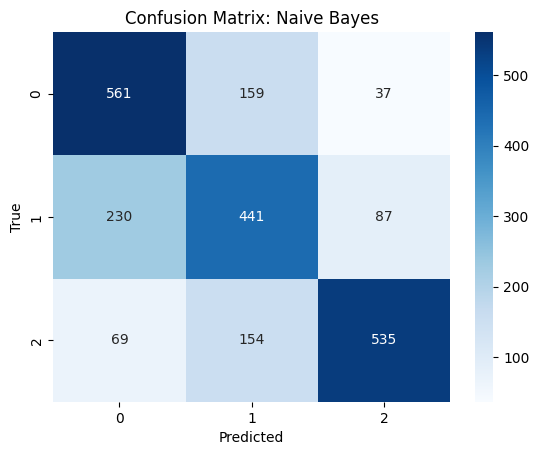

In [29]:
from sklearn.naive_bayes import MultinomialNB

model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)
y_pred_nb = model_nb.predict(X_test_tfidf)

sentiment_metrics_classical["Naive Bayes"] = {
    "Accuracy": accuracy_score(y_test, y_pred_nb),
    "Precision": precision_score(y_test, y_pred_nb, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_nb, average='weighted'),
    "F1": f1_score(y_test, y_pred_nb, average='weighted')
}

print("Multinomial Naive Bayes")
print(classification_report(y_test, y_pred_nb))

sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Random Forest
              precision    recall  f1-score   support

           0       0.64      0.67      0.65       757
           1       0.54      0.61      0.57       758
           2       0.80      0.65      0.71       758

    accuracy                           0.64      2273
   macro avg       0.66      0.64      0.65      2273
weighted avg       0.66      0.64      0.65      2273



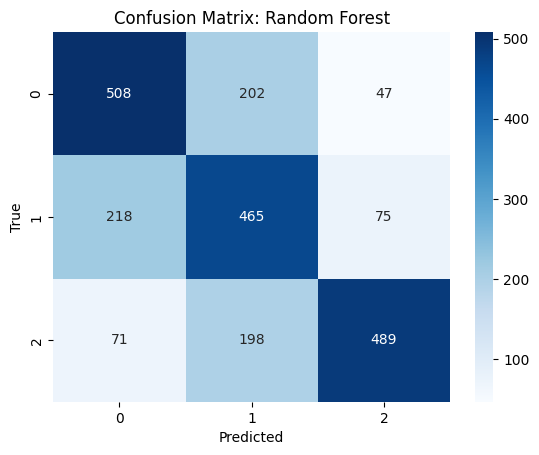

In [30]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_tfidf, y_train)
y_pred_rf = model_rf.predict(X_test_tfidf)

sentiment_metrics_classical["Random Forest"] = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_rf, average='weighted'),
    "F1": f1_score(y_test, y_pred_rf, average='weighted')
}

print("Random Forest")
print(classification_report(y_test, y_pred_rf))

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [31]:
# Convert and save
df_classical_results = pd.DataFrame(sentiment_metrics_classical).T
df_classical_results.to_csv("tfidf_classical_model_results.csv")

# Display
df_classical_results


,Accuracy,Precision,Recall,F1
Logistic Regression,0.680158,0.683197,0.680158,0.681452
SVM,0.662121,0.663587,0.662121,0.662750
Naive Bayes,0.676199,0.683028,0.676199,0.677435
Random Forest,0.643203,0.658439,0.643203,0.647064


In [32]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Disable wandb logging
import os
os.environ["WANDB_DISABLED"] = "true"

# Init global result dictionary
sentiment_metrics_bert = {}


2025-06-13 10:45:53.859501: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 10:45:53.872967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749811553.890032     535 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749811553.895746     535 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749811553.909116     535 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [44]:
def train_distilbert(df, label_map, model_name, class_weights=None):
    from sklearn.model_selection import train_test_split
    from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, TrainingArguments, Trainer
    from datasets import Dataset, DatasetDict
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    import torch
    from torch import nn
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Step 1: Train-Test Split
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df["cleaned_text"].tolist(),
        df["label"].tolist(),
        test_size=0.2,
        stratify=df["label"],
        random_state=42
    )

    # Step 2: Tokenization
    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
    train_encodings = tokenizer(train_texts, truncation=True, padding=True)
    test_encodings = tokenizer(test_texts, truncation=True, padding=True)

    # Step 3: Create HuggingFace datasets
    train_dataset = Dataset.from_dict({
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'label': train_labels
    })
    test_dataset = Dataset.from_dict({
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'label': test_labels
    })
    dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

    # Step 4: Load DistilBERT model
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=len(label_map)
    )

    # ✅ Step 5: Compatible training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_{model_name}",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        save_total_limit=1,
        do_eval=True,
        logging_strategy="steps",
        save_steps=500,
        logging_first_step=True
    )

    # ✅ Step 6: Trainer definition
    if class_weights is not None:
        print(f"⚖️ Using class weights for {model_name}: {class_weights}")
        weights_tensor = torch.tensor(
            list(class_weights.values()),
            dtype=torch.float
        ).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        def compute_loss(model, inputs, return_outputs=False):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss_fn = nn.CrossEntropyLoss(weight=weights_tensor)
            loss = loss_fn(logits, labels)
            return (loss, outputs) if return_outputs else loss

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=dataset["train"],
            eval_dataset=dataset["test"],
            compute_loss=compute_loss
        )
    else:
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=dataset["train"],
            eval_dataset=dataset["test"]
        )

    # Step 7: Train
    trainer.train()

    # Step 8: Predict + Evaluate
    preds = trainer.predict(dataset["test"])
    y_true = np.array(test_labels)
    y_pred = np.argmax(preds.predictions, axis=1)

    # Step 9: Save Metrics
    global sentiment_metrics_bert
    sentiment_metrics_bert[model_name] = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1": f1_score(y_true, y_pred, average='weighted')
    }

    print(f"\n📊 DistilBERT Results: {model_name}")
    print(classification_report(y_true, y_pred, target_names=label_map.keys()))

    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
1,0.683600
10,0.410800
20,0.308200
30,0.188000
40,0.371200
50,0.266200
60,0.240500
70,0.229900
80,0.229800
90,0.173700



📊 DistilBERT Results: DistilBERT_Binary
              precision    recall  f1-score   support

    Negative       0.84      0.82      0.83       929
    Positive       0.98      0.98      0.98      8314

    accuracy                           0.97      9243
   macro avg       0.91      0.90      0.90      9243
weighted avg       0.97      0.97      0.97      9243



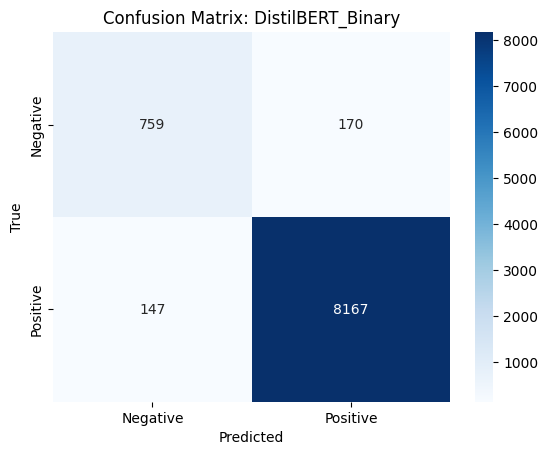

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
1,1.118800
10,1.091300
20,1.102100
30,1.048800
40,1.001800
50,0.870500
60,0.792000
70,0.754300
80,0.705500
90,0.738000



📊 DistilBERT Results: DistilBERT_Balanced
              precision    recall  f1-score   support

    Negative       0.74      0.71      0.72       757
     Neutral       0.58      0.65      0.61       758
    Positive       0.85      0.78      0.81       758

    accuracy                           0.71      2273
   macro avg       0.72      0.71      0.72      2273
weighted avg       0.72      0.71      0.72      2273



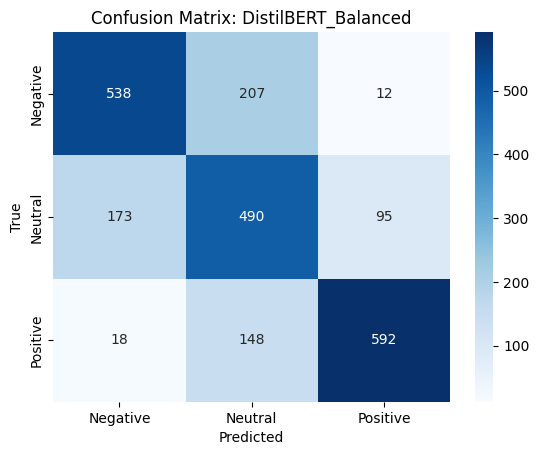

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


⚖️ Using class weights for DistilBERT_Weighted: {0: np.float64(3.5865432895775053), 1: np.float64(4.4010210368805565), 2: np.float64(0.40096874047699244)}


TypeError: Trainer.__init__() got an unexpected keyword argument 'compute_loss'

In [45]:
# Prepare binary label mapping
label_map_bin = {"Negative": 0, "Positive": 1}

# Run 1: Binary sentiment
train_distilbert(df_binary, label_map_bin, "DistilBERT_Binary")

# Prepare 3-class label mapping
label_map_3 = {"Negative": 0, "Neutral": 1, "Positive": 2}

# Run 2: Balanced 3-class
train_distilbert(df_balanced_3class, label_map_3, "DistilBERT_Balanced")

# # Run 3: Full dataset with class weights
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# class_weights_array = compute_class_weight(
#     class_weight="balanced",
#     classes=np.unique(df_full_weighted["label"]),
#     y=df_full_weighted["label"]
# )
# class_weights_dict = {i: w for i, w in enumerate(class_weights_array)}

# train_distilbert(df_full_weighted, label_map_3, "DistilBERT_Weighted", class_weights=class_weights_dict)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
1,1.088200
10,1.121400
20,1.102700
30,1.086600
40,1.090300
50,1.073000
60,1.045000
70,1.005000
80,1.132900
90,0.957200



📊 DistilBERT Results: DistilBERT_Weighted
              precision    recall  f1-score   support

    Negative       0.73      0.72      0.73       930
     Neutral       0.41      0.48      0.44       757
    Positive       0.96      0.95      0.95      8313

    accuracy                           0.89     10000
   macro avg       0.70      0.72      0.71     10000
weighted avg       0.90      0.89      0.89     10000



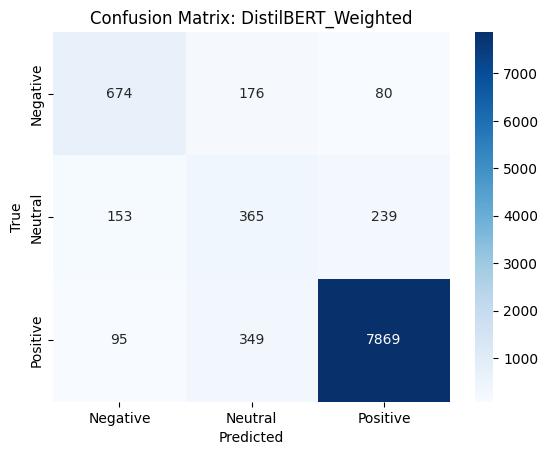

In [47]:
# Prepare 3-class label mapping
label_map_3 = {"Negative": 0, "Neutral": 1, "Positive": 2}

# Step 1: Compute class weights from full dataset
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df_full_weighted["label"]),
    y=df_full_weighted["label"]
)
class_weights_dict = {i: float(w) for i, w in enumerate(class_weights_array)}
weights_tensor = torch.tensor(
    list(class_weights_dict.values()),
    dtype=torch.float
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Step 2: Subclass Trainer to support compute_loss
# class WeightedTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.logits
#         loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor)
#         loss = loss_fn(logits, labels)
#         return (loss, outputs) if return_outputs else loss
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


# Step 3: Reuse core logic from train_distilbert, but call the WeightedTrainer
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_full_weighted["cleaned_text"].tolist(),
    df_full_weighted["label"].tolist(),
    test_size=0.2,
    stratify=df_full_weighted["label"],
    random_state=42
)

# Tokenize
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# Create datasets
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'label': train_labels
})
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'label': test_labels
})
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

# Load model
from transformers import DistilBertForSequenceClassification, TrainingArguments

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

# Training args
training_args = TrainingArguments(
    output_dir="./results_DistilBERT_Weighted",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1,
    do_eval=True,
    logging_strategy="steps",
    save_steps=500,
    logging_first_step=True
)

# Train
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"]
)
trainer.train()

# Evaluate and store
preds = trainer.predict(dataset["test"])
y_true = np.array(test_labels)
y_pred = np.argmax(preds.predictions, axis=1)

# Store results
sentiment_metrics_bert["DistilBERT_Weighted"] = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
    "Recall": recall_score(y_true, y_pred, average='weighted'),
    "F1": f1_score(y_true, y_pred, average='weighted')
}

# Output report
print("\n📊 DistilBERT Results: DistilBERT_Weighted")
print(classification_report(y_true, y_pred, target_names=label_map_3.keys()))

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map_3.keys(), yticklabels=label_map_3.keys())
plt.title("Confusion Matrix: DistilBERT_Weighted")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [48]:
# Save and view
df_bert_results = pd.DataFrame(sentiment_metrics_bert).T
df_bert_results.to_csv("distilbert_model_results.csv")
df_bert_results


,Accuracy,Precision,Recall,F1
DistilBERT_Binary,0.965704,0.965351,0.965704,0.965513
DistilBERT_Balanced,0.712714,0.721594,0.712714,0.716021
DistilBERT_Weighted,0.890800,0.897943,0.890800,0.894105
